Shape of PCA components: (10, 22)


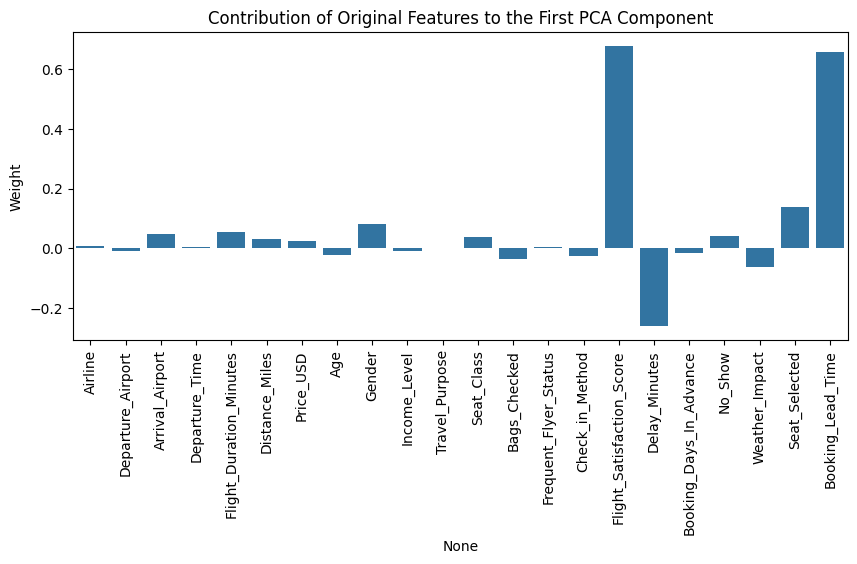

600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<ipython-input-1-d2de7d2faaeb>:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["PCA", "Autoencoder"], y=[acc_pca, acc_ae], palette="Set2")


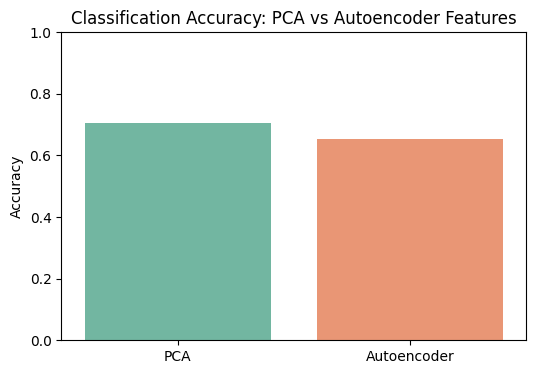

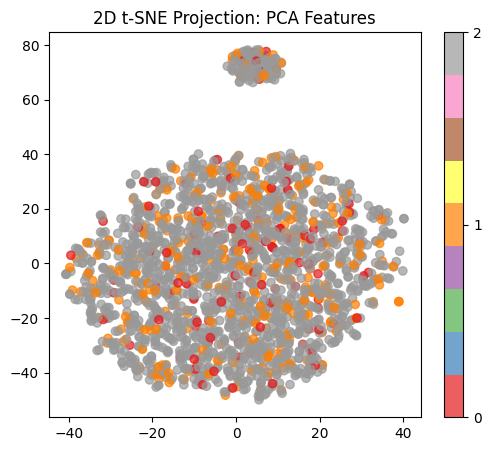

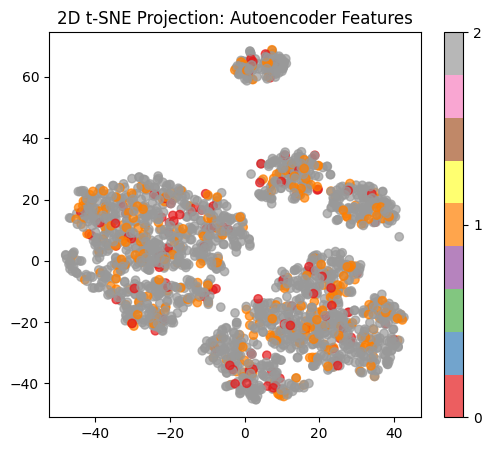


=== PCA Features Classification Report ===
               precision    recall  f1-score   support

   Cancelled       0.06      0.05      0.05       106
     Delayed       0.21      0.18      0.19       294
     On-time       0.81      0.85      0.83      1600

    accuracy                           0.70      2000
   macro avg       0.36      0.36      0.36      2000
weighted avg       0.69      0.70      0.69      2000


=== Autoencoder Features Classification Report ===
               precision    recall  f1-score   support

   Cancelled       0.03      0.04      0.04       106
     Delayed       0.16      0.17      0.16       294
     On-time       0.80      0.79      0.79      1600

    accuracy                           0.66      2000
   macro avg       0.33      0.33      0.33      2000
weighted avg       0.67      0.66      0.66      2000



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE

# For balancing classes
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import set_random_seed

import os

DATA_PATH = 'DS2/df.csv'

# --- LOAD DATA ---
df = pd.read_csv(DATA_PATH)

# --- PREPROCESSING ---
id_cols = ["Passenger_ID", "Flight_ID"]
df = df.drop(columns=id_cols, errors='ignore')

# Target variable (example: classify On-time, Delayed, Cancelled)
TARGET = "Flight_Status"
df = df[df[TARGET].isin(["On-time", "Delayed", "Cancelled"])]

# Split features/target
X = df.drop(columns=[TARGET])
y = df[TARGET]

# Encode categorical columns
cat_cols = X.select_dtypes(include='object').columns
for col in cat_cols:
    X[col] = X[col].fillna('NA')
    enc = LabelEncoder()
    X[col] = enc.fit_transform(X[col].astype(str))

# Fill missing numerics
X = X.fillna(X.median(numeric_only=True))

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)

# --- TRAIN/TEST SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# ADDRESS CLASS IMBALANCE (SMOTE)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# 1. FEATURE EXTRACTION: PCA
n_components = 10
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_bal)
X_test_pca = pca.transform(X_test)

# Access the principal components
pca_components = pca.components_

# Print the shape of the components (n_components, n_original_features)
print("Shape of PCA components:", pca_components.shape)

plt.figure(figsize=(10, 4))
sns.barplot(x=X.columns, y=pca_components[0])
plt.title("Contribution of Original Features to the First PCA Component")
plt.xticks(rotation=90)
plt.ylabel("Weight")
plt.show()

# Classification on PCA features
rf_pca = RandomForestClassifier(random_state=42)
rf_pca.fit(X_train_pca, y_train_bal)
y_pred_pca = rf_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca)

# 2. FEATURE EXTRACTION: AUTOENCODER
set_random_seed(42)
encoding_dim = n_components

input_dim = X_train_bal.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(
    X_train_bal, X_train_bal,
    epochs=30, batch_size=32, shuffle=True,
    validation_split=0.1, verbose=0
)
X_train_ae = encoder.predict(X_train_bal)
X_test_ae = encoder.predict(X_test)

# Classification on Autoencoder features
rf_ae = RandomForestClassifier(random_state=42)
rf_ae.fit(X_train_ae, y_train_bal)
y_pred_ae = rf_ae.predict(X_test_ae)
acc_ae = accuracy_score(y_test, y_pred_ae)

# VISUALIZATIONS

# 1. Accuracy Comparison
plt.figure(figsize=(6,4))
sns.barplot(x=["PCA", "Autoencoder"], y=[acc_pca, acc_ae], palette="Set2")
plt.title("Classification Accuracy: PCA vs Autoencoder Features")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

# 2. 2D Projection (PCA vs Autoencoder)
def plot_2d_projection(X_proj, y_true, title):
    tsne = TSNE(n_components=2, random_state=42, learning_rate='auto', init='pca')
    X_2d = tsne.fit_transform(X_proj)
    plt.figure(figsize=(6,5))
    scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=y_true, cmap='Set1', alpha=0.7)
    plt.title(title)
    plt.colorbar(scatter, ticks=range(len(np.unique(y_true))))
    plt.show()

plot_2d_projection(X_test_pca, y_test, "2D t-SNE Projection: PCA Features")
plot_2d_projection(X_test_ae, y_test, "2D t-SNE Projection: Autoencoder Features")

# 3. Classification Reports
print("\n=== PCA Features Classification Report ===\n", classification_report(y_test, y_pred_pca, target_names=le.classes_))
print("\n=== Autoencoder Features Classification Report ===\n", classification_report(y_test, y_pred_ae, target_names=le.classes_))
